In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('..')
sys.path.append('../..')

from library import ModelStatistics, SemanticHeterogenityRegularizer
from library import custom_fit_offline, weigh_average

import artm

In [2]:
DATA_PATH = '../data/lenta_22.vw'
BATCH_PATH = '../data/lenta_22_batches'
DICT_PATH = '../data/lenta_22.dict'

batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
    dictionary_lenta.save(DICT_PATH)
dictionary_lenta.load(DICT_PATH)

## Semantic heterogenity regularizer

In [ ]:
model_lenta = artm.ARTM(num_topics=22, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

statistics = ModelStatistics(model_lenta)
custom_regularizers = [
    SemanticHeterogenityRegularizer('heterogenity', 0.05, statistics, batch_vectorizer_lenta)
]

custom_fit_offline(model_lenta, custom_regularizers, batch_vectorizer_lenta, 15)

In [4]:
model_lenta_unbalanced = artm.ARTM(num_topics=22, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(dictionary_lenta)

model_lenta_unbalanced.fit_offline(batch_vectorizer_lenta, 15)

In [5]:
statistics = ModelStatistics(model_lenta_unbalanced)

In [6]:
topic_stat = statistics.calculate_topic_statistics(batch_vectorizer_lenta, calculate_n=True, recalculate_n=False)

../library/statistics.py:146: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)


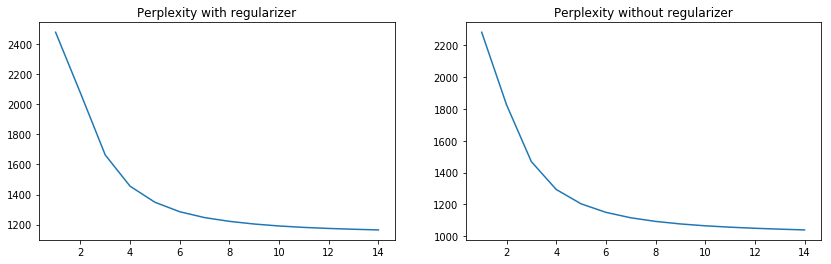

In [10]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

plt.subplot(1,2,2)
values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

### Train many models

In [2]:
def train_model_with_heterogenity(dictionary, batch_vectorizer, tau, num_topics=22, num_iterations=15):
    model = artm.ARTM(num_topics, cache_theta=True)
    model.scores.add(artm.scores.PerplexityScore(name='perplexity'))
    model.initialize(dictionary)

    statistics = ModelStatistics(model)
    custom_regularizers = [
        SemanticHeterogenityRegularizer('heterogenity', tau, statistics, batch_vectorizer)
    ]

    custom_fit_offline(model, custom_regularizers, batch_vectorizer, num_iterations)

    return model, statistics

In [3]:
def train_models_with_heterogenity(dictionary, batch_vectorizer, num_topics, all_possible_taus=None, num_iterations=15):
    if all_possible_taus is None:
        all_possible_taus = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    model_statistics_time = {}
    for tau in all_possible_taus:
        start_time = time.time()
        model, statistics = train_model_with_heterogenity(dictionary, batch_vectorizer, tau, num_topics, num_iterations)
        end_time = time.time()

        model_statistics_time[tau] = (model, statistics, end_time - start_time)

        print(f'Consumed time for tau {tau}: {end_time - start_time}.')
        
    topic_statistics = {}
    for tau, mod_stat_time in model_statistics_time.items():
        topic_statistics[tau] = mod_stat_time[1].calculate_topic_statistics(batch_vectorizer)

    return model_statistics_time, topic_statistics

In [4]:
def plot_statistics(model_statistics_time, topic_statistics, plotname=None):
    plt.rc('font', size=25)
    colors = ['crimson', 'mediumpurple', 'steelblue', 'forestgreen', 'khaki', 'orange', 'salmon', 'lightgreen', 'deeppink', 'navy', 'teal']
    titles = [
        'Семантическая неоднородность от n_t',
        'Бинарная семантическая неоднородность от n_t',
        'Семантическая неоднородность с бинарной функцией потерь от n_t',
        'Бинарная семантическая неоднородность с бинарной функцией потерь от n_t',
        'Семантическая загрязнённость от n_t',
        'Бинарная семантическая загрязнённость от n_t',
        'Семантическая загрязнённость с бинарной функцией потерь от n_t',
        'Бинарная семантическая загрязнённость с бинарной функцией потерь от n_t'
    ]

    num_subplots = len(topic_statistics)
    num_statistics = len(titles)

    fig = plt.figure(figsize=(128,8 * num_subplots))

    for ind, (tau, stat) in enumerate(topic_statistics.items()):
        for i in range(num_statistics):
            plt.subplot(num_subplots, num_statistics, ind * num_statistics + 1 + i)
            plt.scatter(model_statistics_time[tau][1].nt, stat[i], c=colors[ind])

            plt.xlabel('n_t')
            plt.ylabel(f'tau={tau}')

            if not ind:
                plt.title(titles[i])

            if i:
                plt.ylim(-0.05, 1.05)
            else:
                plt.ylim(-0.05, max(stat[0]) + 0.1)

    fig.tight_layout()
    
    if plotname is not None:
        plt.savefig(plotname)

In [10]:
model_statistics_time, topic_statistics = train_models_with_heterogenity(dictionary_lenta, batch_vectorizer_lenta, 2, [1, 0.1], 2)

Consumed time for tau 1: 457.25625920295715.
Consumed time for tau 0.1: 457.4624409675598.


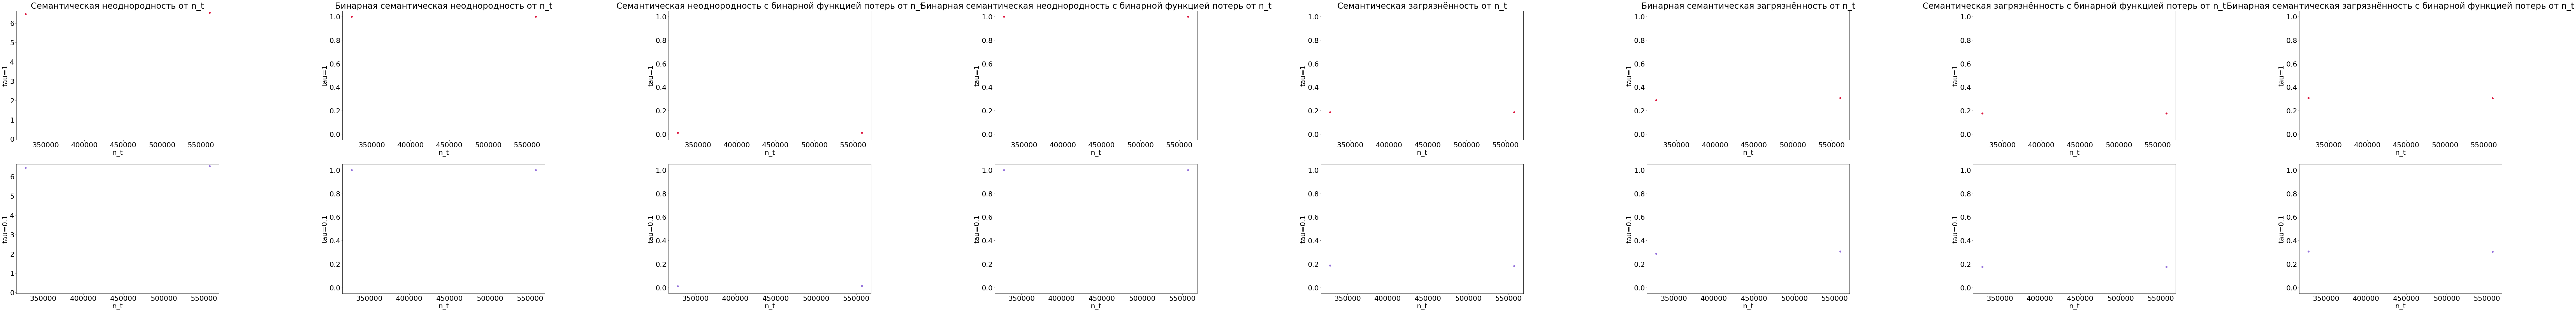

In [23]:
plot_statistics(model_statistics_time, topic_statistics)

### Train many more models

In [ ]:
del topic_stat
del model_statistics_time

import rc
rc.collect()

In [ ]:
all_possible_taus = [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

model_statistics_time = {}
for tau in all_possible_taus:
    start_time = time.time()
    model, statistics = train_model_with_heterogenity(dictionary_lenta, batch_vectorizer_lenta, tau, 75)
    end_time = time.time()

    model_statistics_time[tau] = (model, statistics, end_time - start_time)

    print(f'Consumed time for tau {tau}: {end_time - start_time}.')

---

In [ ]:
topic_stat = {}
for tau, mod_stat_time in model_statistics_time.items():
    topic_stat[tau] = mod_stat_time[1].calculate_topic_statistics(batch_vectorizer_lenta)

In [ ]:
plt.rc('font', size=25)
colors = ['crimson', 'mediumpurple', 'steelblue', 'forestgreen', 'khaki', 'orange', 'salmon']
titles = [
    'Семантическая неоднородность от n_t',
    'Бинарная семантическая неоднородность от n_t',
    'Семантическая неоднородность с бинарной функцией потерь от n_t',
    'Бинарная семантическая неоднородность с бинарной функцией потерь от n_t',
    'Семантическая загрязнённость от n_t',
    'Бинарная семантическая загрязнённость от n_t',
    'Семантическая загрязнённость с бинарной функцией потерь от n_t',
    'Бинарная семантическая загрязнённость с бинарной функцией потерь от n_t'
]

num_subplots = len(topic_stat)
num_statistics = len(titles)

In [ ]:
fig = plt.figure(figsize=(128,64))

for ind, (tau, stat) in enumerate(topic_stat.items()):
    for i in range(num_statistics):
        plt.subplot(num_subplots, num_statistics, ind * num_statistics + 1 + i)
        plt.scatter(model_statistics_time[tau][1].nt, stat[i], c=colors[ind])

        plt.xlabel('n_t')
        plt.ylabel(f'tau={tau}')

        if not ind:
            plt.title(titles[i])

        if i:
            plt.ylim(-0.05, 1.05)
        else:
            plt.ylim(-0.05, max(stat[0]) + 0.1)

fig.tight_layout()
plt.savefig('statistics_75.png')

## Plot MIL datasets

In [5]:
import gc

gc.collect()

20

In [6]:
from topicnet.cooking_machine import Dataset

In [8]:
NG20 = '/data/datasets/20_News_dataset/train_preprocessed.csv'
MKB10 = '/data/datasets/MKB10_wiki/MKB10.csv'
NIPS = '/data/datasets/NIPS/ReadyData.csv'

In [9]:
dictionaries = []
batch_vectorizers = []
nums_topics = [20, 25, 10, 30]
names = ['20newsgroups', 'mkb10', 'nips10', 'nips30']

In [13]:
DATA_PATH = '../data/NIPS.vw'
BATCH_PATH = '../data/NIPS_batches'
DICT_PATH = '../data/NIPS.dict'

batch_vectorizer = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary.gather(data_path=batch_vectorizer.data_path)
    dictionary.save(DICT_PATH)
dictionary.load(DICT_PATH)

dictionaries.append(dictionary)
batch_vectorizers.append(batch_vectorizer)

In [ ]:
all_model_statistics_time = {}

for (dictionary, batch_vectorizer, num_topics, name) in zip(dictionaries, batch_vectorizers, nums_topics, names):
    model_statistics_time, topic_statistics = train_models_with_heterogenity(dictionary, batch_vectorizer, num_topics)
    all_model_statistics_time[name] = (model_statistics_time, topic_statistics)
    plot_statistics(model_statistics_time, topic_statistics, name)

    gc.collect()